# Selection Bias in Observational Data

A fitness app launches streak reminders to encourage workouts. You want the causal effect on weekly workout sessions.

Two rollouts:
1.	**Observational (opt-in)**: Users choose to enable reminders.
2.	**Randomized (RCT)**: The app randomly assigns reminders to 50% of users.

We’ll show why the observational comparison is biased upward when *motivated* users are more likely to opt in.

### Notation

Consider user $i$.
- $Y_i(1)$: user $i$’s weekly workouts if they have the reminder (treatment).
- $Y_i(0)$: user $i$’s weekly workouts if not treated (control).
- $\Delta_i \equiv Y_i(1)-Y_i(0)$: individual causal effect.
- $D_i \in \{0,1\}$: observational/opt-in indicator (1 if the user chose reminders).
- $T_i \in \{0,1\}$: randomized assignment (1 if randomly assigned reminders).
- $v_i$: unobserved motivation (high $v_i$ ⇒ tends to work out more and is more likely to opt in).

Observed outcomes:
- Under opt-in: $Y_i^{\text{obs}} = D_i\,Y_i(1) + (1-D_i)\,Y_i(0)$.
- Under RCT: $Y_i^{\text{obs}} = T_i\,Y_i(1) + (1-T_i)\,Y_i(0)$.

### Comparing Two Estimands

- SDO (selection-distorted observational difference):
$$\text{SDO} \equiv \mathbb{E}[Y^{\text{obs}}\mid D=1]-\mathbb{E}[Y^{\text{obs}}\mid D=0]
= \mathbb{E}[Y(1)\mid D=1]-\mathbb{E}[Y(0)\mid D=0]$$
- ATE (average treatment effect via RCT)
$$\text{ATE} \equiv \mathbb{E}[Y^{\text{obs}}\mid T=1]-\mathbb{E}[Y^{\text{obs}}\mid T=0]
= \mathbb{E}[Y(1)-Y(0)] \quad \text{(because } T \perp \{Y(0),Y(1)\}\text{)}$$

### Why the observayional SDO is biased

Bias decomposition:
\begin{aligned}
\text{SDO}
&= \underbrace{\mathbb{E}\!\left[Y(1)-Y(0)\mid D=1\right]}{\text{effect among opt-ins}}
\;+\;
\underbrace{\Big(\mathbb{E}[Y(0)\mid D=1]-\mathbb{E}[Y(0)\mid D=0]\Big)}{\textbf{selection term}}.
\end{aligned}

If high-motivation users ($v$ large) both (i) opt in (D=1) and (ii) have higher baseline workouts Y(0), then the selection term > 0, so SDO > ATE on average (upward bias).

### Doing the Simulation

We simulate heterogeneous effects and selection on an unobserved $v$
- $\Delta_i \sim \mathcal{N}(0.5,\,0.2^2)$ (mean effect ≈ +0.5 workouts/week).
- We draw $(e_{0i}, e_{1i}, v_i)$ from a trivariate normal with positive correlations so that more motivated users tend to have higher outcomes in both states and also opt in.

Potential outcomes:
$$Y_i(0) = e_{0i}, \quad Y_i(1) = e_{1i} + \Delta_i$$
- Opt-in rule: $D_i = \mathbf{1}\{v_i>0\}$.
- RCT: $T_i \sim \text{Bernoulli}(0.5)$.

We’ll compute SDO, ATE, and also display the selection term to see the bias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

In [2]:
# Correlated shocks for [e0, e1, v] to induce selection on unobservables
mu = np.array([0.0, 0.0, 0.0])
Sigma = np.array([
    [1.0, 0.6, 0.4],  # e0 with e1, v
    [0.6, 1.0, 0.4],  # e1 with e0, v
    [0.4, 0.4, 1.0]   # v  with e0, e1
])

n = 100_000

# Heterogeneous treatment effects around +0.5
delta = np.random.normal(loc=0.5, scale=0.2, size=n)

# Draw (e0, e1, v)
E = np.random.multivariate_normal(mu, Sigma, size=n)
e0 = E[:, 0]
e1 = E[:, 1]
v  = E[:, 2]

# Potential outcomes
y0 = e0
y1 = e1 + delta

# Observational assignment (opt-in if motivated)
D = (v > 0).astype(int)

# Randomized assignment (50/50)
T = np.random.binomial(1, 0.5, size=n)

# Observed outcomes
y_obs_obs = D * y1 + (1 - D) * y0
y_obs_rct = T * y1 + (1 - T) * y0

# Estimands
SDO = y_obs_obs[D == 1].mean() - y_obs_obs[D == 0].mean()
ATE = y_obs_rct[T == 1].mean() - y_obs_rct[T == 0].mean()
true_ATE = delta.mean()

# Bias decomposition pieces
effect_among_optins = (y1 - y0)[D == 1].mean()
selection_term = y0[D == 1].mean() - y0[D == 0].mean()

print(f"One run — SDO (observational): {SDO:.3f}")
print(f"One run — ATE (randomized)   : {ATE:.3f}")
print(f"True average effect δ̄        : {true_ATE:.3f}\n")

print("Bias decomposition for SDO:")
print(f"  E[Y(1)-Y(0) | D=1]    = {effect_among_optins:.3f}")
print(f"  E[Y(0)|D=1]-E[Y(0)|D=0]= {selection_term:.3f}  (selection)")
print(f"  Sum (≈ SDO)           = {(effect_among_optins + selection_term):.3f}")

One run — SDO (observational): 1.135
One run — ATE (randomized)   : 0.501
True average effect δ̄        : 0.499

Bias decomposition for SDO:
  E[Y(1)-Y(0) | D=1]    = 0.496
  E[Y(0)|D=1]-E[Y(0)|D=0]= 0.639  (selection)
  Sum (≈ SDO)           = 1.135


Now lets see this for a larger sample

In [3]:
nsample = 1000   # per simulated study
nsim = 10_000

sdo_vals = []
ate_vals = []
true_deltas = []

for _ in range(nsim):
    delta = np.random.normal(loc=0.5, scale=0.2, size=nsample)
    E = np.random.multivariate_normal(mu, Sigma, size=nsample)
    e0, e1, v = E[:,0], E[:,1], E[:,2]

    y0 = e0
    y1 = e1 + delta

    D = (v > 0).astype(int)
    T = np.random.binomial(1, 0.5, size=nsample)

    y_obs_obs = D * y1 + (1 - D) * y0
    y_obs_rct = T * y1 + (1 - T) * y0

    sdo_vals.append(y_obs_obs[D == 1].mean() - y_obs_obs[D == 0].mean())
    ate_vals.append(y_obs_rct[T == 1].mean() - y_obs_rct[T == 0].mean())
    true_deltas.append(delta.mean())

sdo_vals = np.array(sdo_vals)
ate_vals = np.array(ate_vals)
true_deltas = np.array(true_deltas)

print(f"Average SDO over sims : {sdo_vals.mean():.3f}")
print(f"Average ATE over sims : {ate_vals.mean():.3f}")
print(f"Average true δ̄       : {true_deltas.mean():.3f}")

Average SDO over sims : 1.138
Average ATE over sims : 0.500
Average true δ̄       : 0.500


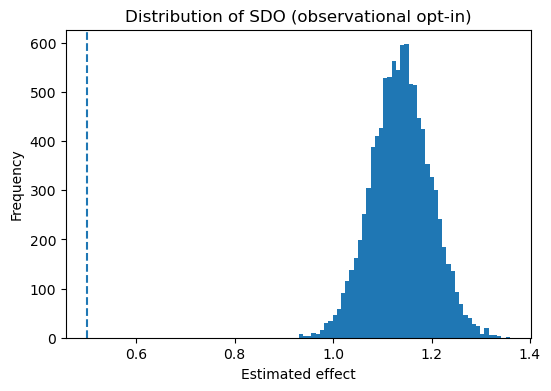

In [4]:
# SDO distribution (observational)
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(sdo_vals, bins=50)
ax.axvline(true_deltas.mean(), linestyle='--')
ax.set_title("Distribution of SDO (observational opt-in)")
ax.set_xlabel("Estimated effect")
ax.set_ylabel("Frequency")
plt.show()

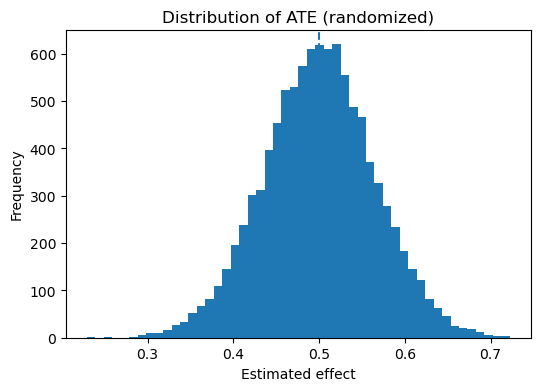

In [5]:
# ATE distribution (randomized)
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(ate_vals, bins=50)
ax.axvline(true_deltas.mean(), linestyle='--')
ax.set_title("Distribution of ATE (randomized)")
ax.set_xlabel("Estimated effect")
ax.set_ylabel("Frequency")
plt.show()

### Key Takeaways

$Y(1)$ and $Y(0)$ are the counterfactual outcomes with and without reminders. We never observe both; we observe one based on assignment.
- With opt-in, treatment $D$ is related to unobserved motivation $v$, which also shifts $Y(0)$. This makes $\mathbb{E}[Y(0)\mid D=1] \neq \mathbb{E}[Y(0)\mid D=0]$ ⇒ selection term ≠ 0 ⇒ bias.
- With randomization, $T \perp \{Y(0),Y(1)\}$. Thus the treatment–control difference equals $\mathbb{E}[Y(1)-Y(0)]$, the causal ATE.
- In simulations, SDO > ATE on average (upward bias) when motivated users are more likely to opt in.